Date: Saturday October 17, 2015, Minneapolis Fed.

# Kalman Filter

https://python.quantecon.org/kalman.html

###### The Kalman Filter: 
suppose that we have a prior distribution about the state and we receive a noisy signal about that state. The Kalman filter tells us how to combine (i.e. filter out the noise from) the signal and the prior to update our belief about the distribution of the state. If the signal was observed without noise, the best predictor would be given by the conditional expectation.

###### This code implements the Kalman Filter.

Step 1: Filtering noise: combine prior with noisy signal to get posterior of state.

Consider a state variable of interest $x$ with prior distribution $p \sim N(\hat{x}, \Sigma)$.

The state variable is not observed but a noisy signal $y$ is observable where:
\begin{equation*}
y = G x + v \quad \quad \text{where} \ v \sim_{iid} N(0, R)
\end{equation*}

Given, $x$, the conditional distribution of y is $y\lvert x  \sim N(G x, R)$.

The posterior distribution of $x$ is given by Bayes's Rule:
\begin{equation*}
p(x \lvert y) = \frac{p(y,x)}{p(y)} = \frac{p(y \lvert x) \cdot p(x)}{\int_x p(y \lvert x) p(x) d_x}
\end{equation*}
Since $p(y \lvert x)$ is normal and $p(x)$ is normal, the Filtering Distribution (posterior) is: 
\begin{align*}
x \lvert y \sim & N(\hat{x}^F, \Sigma^F) \quad \text{where}\\
& \hat{x}^F = \hat{x} + \kappa (y - G \hat{x}) \\
& \Sigma^F = \Sigma - \kappa G \Sigma\\
& \kappa = \Sigma G^T (G \Sigma G^T + R)^{-1}
\end{align*}
$\kappa$ is known as the Kalman Gain: it is the sensitivity of the posterior to the difference between the signal $y$ and its expected value based on the prior $G \hat{x}$; it also is sensitivity of the decrease in variance brought by the additional information.


###Step 2: Prediction: combine filtering distribution (step 1) with law of motion
We now introduce time and the law of motion of $x_t$ is given by:
\begin{equation*}
x_{t+1} = A x_{t} + w_{t+1} \quad \quad \text{where} \ w_t \sim_{iid} N(0, Q)
\end{equation*}

Now we want to use the Filtering Distribution $N(\hat{x}_t^F, \Sigma_t^F)$ of $x_t \lvert y_t$ and the law of motion to predict $\hat{x}_{t+1} \equiv E[x_{t+1} \lvert y_t, \ldots, y_0]$.

The prior distribution of $x_{t+1}$ is given $N(\hat{x}_{t+1}, \Sigma_{t+1})$ where:
\begin{align*}
\hat{x}_{t+1} &= A \hat{x}_t^F \\
&= A \ \hat{x}_t + A \ \kappa_t (y_t - G \hat{x}_t)\\
\Sigma_{t+1} &= A \Sigma^F_t A^T + Q\\
&= A (\Sigma_t - \kappa_t G \Sigma_t) A^T + Q
\end{align*}
where $A \kappa_t =  A\Sigma_t G^T (G \Sigma_t G^T + R)^{-1}$ denotes the Kalman Gain.

Note that the predictive distribution $N(\hat{x}_{t+1}, \Sigma_{t+1})$ can be computed recursively: it only depends on parameters of the model: $A, G, Q, R$ and the filtering distribution $N(\hat{x}_t^F, \Sigma_t^F)$ which itself only depends on the predictive distribution $N(\hat{x}_{t}, \Sigma_{t})$ and the signal $y_t$.

### A simple example for the scalar case.
Suppose:
\begin{align*}
x_0 &\sim N(\theta_0, \sigma) \quad \quad \quad \quad \quad \quad \text{prior}\\
y_t &= x_t + v_t, \quad v_t \sim_{iid} N(0,r) \quad \quad \text{signal}\\
x_{t+1} &= \rho x_t + \epsilon_{t+1} \quad \epsilon_t \sim_{iid} N(0,q) \quad \text{law of motion}\\
\end{align*}

The Kalman filter gives:
- posterior on $x_t$ is $x_t \lvert y_t \sim N(\theta^F, \sigma^F)$ where:
\begin{align*}
\theta^F & = \frac{r \theta_t + \sigma y}{\sigma + r} = \frac{\frac{1}{\sigma} \theta_t + \frac{1}{r} y}{\frac{1}{\sigma} + \frac{1}{r}} \\
\sigma^F & = \frac{\sigma r}{\sigma + r} = \left(\frac{1}{\sigma} + \frac{1}{r}\right)^{-1}
\end{align*}

- predictive distrib of $x_{t+1}$ is $x_{t+1} \lvert y_t \sim N(\rho \theta^F, \rho^2 \sigma^F + q)$:


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division
import numpy as np
from numpy.linalg import inv
from numpy import dot

'''
Functions to apply the Kalman Filter for the following state space model
    x' = A x + w where w iid N(0, Q)
    y = G x + v where v iid N(0, R)
    prior on x is N(x_hat, Sigma)
'''

def Kalman_FilteringDist(x_hat, y, Sigma, A, G, Q, R):
    '''
    Returns the mean x_hat_F and variance Sigma_F of the Normal Filtering Distribution.
    Code: return x_hat, SigmaF = Kalman_FilteringDist(...
        x' = A x + w where w iid N(0, Q)
        y = G x + v where v iid N(0, R)
        prior on x is N(x_hat, Sigma)
        Posterior is N(x_hat_F, Sigma_F)
    '''
    Kalmanbuild = np.linalg.inv(dot(dot(G, Sigma), G.T) + R)
    KalmanGainF = dot(dot(Sigma, G.T), Kalmanbuild)
    x_hatF = x_hat + dot(KalmanGainF, (y - dot(G, x_hat)))
    SigmaF = Sigma - dot(KalmanGainF, dot(G, Sigma))
    return x_hatF, SigmaF

def Kalman_PredictDist(x_hat, y, Sigma, A, G, Q, R):
    '''
    Returns the prior distribution for x' given the filtering distribution on x and the observation y
    Code: x_hat_prime, Sigma_prime = Kalman_PredictDist(x_hat, y, Sigma, A, G, Q, R)
        x' = A x + w where w iid N(0, Q)
        y = G x + v where v iid N(0, R)
        prior on x is N(x_hat, Sigma)
        Kalman_FilteringDist is the function that gives the filtering distribution (posterior on x from prior on x and observation y)
    '''
    x_hatF, SigmaF = Kalman_FilteringDist(x_hat, y, Sigma, A, G, Q, R)
    x_hat_prime = dot(A, x_hatF)
    Sigma_prime = dot(A, dot(SigmaF, A.T)) + Q
    return x_hat_prime, Sigma_prime

#def Kalman_Predict_next_T(T, x, y, Sigma, A, G, Q, R):

Quantecon/A First Look at the Kalman Filter / Exercise 1, http://quant-econ.net/py/kalman.html

\begin{align*}
x_t &= \theta, \quad \theta \ \text{unknown}\\
y_t &= x_t + v_t \quad \quad v_t \sim N(0,1)
\end{align*}

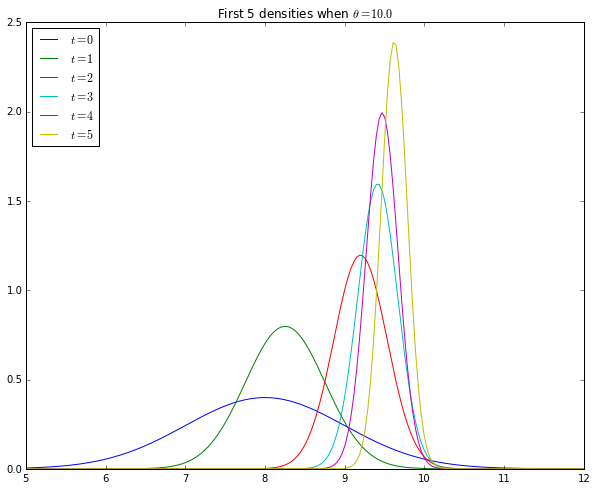

In [3]:
from scipy.stats import norm
'''
Parameters of the state space model:
    x' = A x + w where w iid N(0, Q)
    y = G x + v where v iid N(0, R)
    prior on x is N(init_x, init_Sigma)
'''
theta = 10
A = np.array([[1]])
G = np.array([[1]])
Q = np.array([[0]])
R = np.array([[1]])

init_x = np.array([8])
init_Sigma = np.array([[1]])

'''
Main loop
'''
T = 5
X_hat = [init_x]
Sigma_hat = [init_Sigma]
v = np.random.normal(0,1,T)

for i in range(T):
    y = dot(G, theta) + v[i]
    x_hat_prime, Sigma_prime = Kalman_PredictDist(init_x, y, init_Sigma, A, G, Q, R)
    X_hat.append(x_hat_prime)
    Sigma_hat.append(Sigma_prime)
    init_x = x_hat_prime
    init_Sigma = Sigma_prime

#print results == #
    #print X_hat, 'X_hat'
    #print Sigma_hat, 'Sigma_hat'


# == set up plot == #
fig, ax = plt.subplots(figsize=(10,8))
xgrid = np.linspace(theta - 5, theta + 2, 200)

for i in range(T+1):
    # == record the current predicted mean and variance == #
    m, v = [X_hat[i], Sigma_hat[i]]
    m.shape = (1,)
    v.shape = (1,)
    # == plot, update filter == #
    ax.plot(xgrid, norm.pdf(xgrid, loc=m, scale= v), label=r'$t=%d$' % i)

ax.set_title(r'First %d densities when $\theta = %.1f$' % (T, theta)) 
ax.legend(loc='upper left')


Quantecon/A First Look at the Kalman Filter / Exercise 2, http://quant-econ.net/py/kalman.html

\begin{align*}
x_t &= \theta, \quad \theta \ \text{unknown}\\
y_t &= x_t + v_t \quad \quad v_t \sim N(0,1)
\end{align*}

Now compute the prediction error
\begin{equation*}
z_t = 1 - \int_{\theta - \epsilon}^{\theta + \epsilon} p_t(x) d_x
\end{equation*}
where $p_t$ is the Kalman Predictive distribution after $t$ periods.

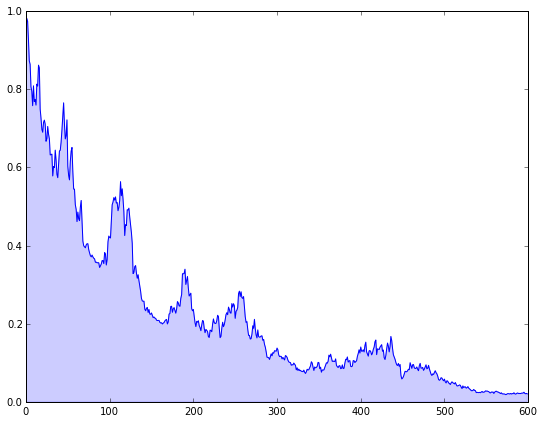

In [130]:
from scipy.stats import norm
from scipy.integrate import quad
'''
Parameters of the state space model:
    x' = A x + w where w iid N(0, Q)
    y = G x + v where v iid N(0, R)
    prior on x is N(init_x, init_Sigma)
'''
theta = 10
A = np.array([[1]])
G = np.array([[1]])
Q = np.array([[0]])
R = np.array([[1]])

init_x = np.array([8])
init_Sigma = np.array([[1]])

'''
Main loop
'''
T = 600
epsilon = 0.1
X_hat = [init_x]
Sigma_hat = [init_Sigma]
v = np.random.normal(0,1,T)
z = np.empty(T)

def norm_pdf(x, m, v):
    return norm.pdf(x, loc=m, scale=np.sqrt(v))

for i in range(T):
    y = dot(G, theta) + v[i]
    x_hat_prime, Sigma_prime = Kalman_PredictDist(init_x, y, init_Sigma, A, G, Q, R)
    x_hat_prime.shape = (1,)
    Sigma_prime.shape = (1,)
    integral, error = quad(lambda x: norm_pdf(x, x_hat_prime, Sigma_prime), theta - epsilon, theta + epsilon)
    z[i] = 1 - integral
    init_x = x_hat_prime
    init_Sigma = Sigma_prime

fig, ax = plt.subplots(figsize=(9, 7))
ax.set_ylim(0, 1)
ax.set_xlim(0, T)
ax.plot(range(T), z) 
ax.fill_between(range(T), np.zeros(T), z, color="blue", alpha=0.2) 

Quantecon/A First Look at the Kalman Filter / Exercise 3, http://quant-econ.net/py/kalman.html

We now compare the prediction error of the Kalman filter and the prediction error of the conditional expectation (conditional expectation is computed based on the previous value of the state while the Kalman filter is computed based on a noisy signal of the previous value of the state). As we saw in econometrics, the conditional expectation is a good predictor in the sense that it minimizes the mean squarred error.

\begin{align*}
x_{t+1} &= A x_t + w_t \quad w_t \sim_{iid} N(0,Q) \\
y_t &= x_t + v_t \quad \quad v_t \sim_{iid} N(0,R)
\end{align*}

So the conditional expectation predictor is: 
\begin{equation*}
E[x_{t+1} \lvert x_t] = A x_t
\end{equation*}

The Kalman prediction is:
\begin{equation*}
\hat{x}_{t+1} = A \hat{x}_t^F
\end{equation*}
where $\hat{x}_t^F$ is the mean of the Filtering Distribution.

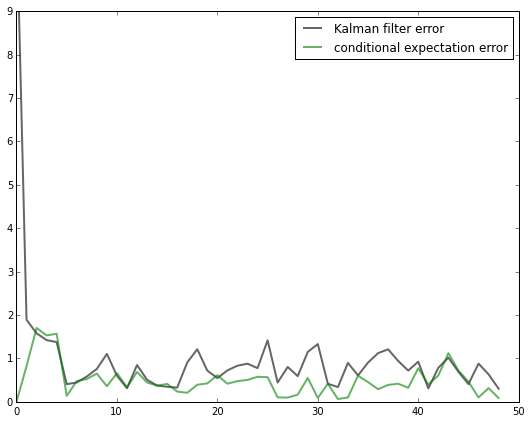

In [144]:
A = np.array([[0.5, 0.4], 
              [0.6, 0.3]])
G = np.eye(2)
Q = 0.3 * np.eye(2)
R = 0.5 * np.eye(2)

init_x_hat = np.array([[8], [8]])
init_Sigma = np.array([[0.9, 0.3],
                       [0.3, 0.9]])

T = 50

'''
Generate the sequence of states X and conditional expectations
'''
X = [] #records the sequence of the state variable
X.append(np.array([[0],[0]]))
AX = [] #records the sequence of conditional expectation of the state variable E[x_{t+1} : x] = Ax
Kalman = [] #records the sequence of Kalman predictions
Conditional_predict_error = []
Kalman_predict_error = []
for i in range(T-1):
    AX.append(dot(A, X[i]))
    Cpredictionerror = np.linalg.norm(AX[i] - X[i])
    Conditional_predict_error.append(Cpredictionerror)
    w = np.random.multivariate_normal(np.array([0, 0]), Q)
    w.shape = (2,1)
    X.append(dot(A, X[i]) + w)

'''
Generate the sequence of Kalman predictions
'''
for i in range(T-1):
    Kalman.append(init_x_hat)
    Kpredictionerror = np.linalg.norm(Kalman[i] - X[i])
    Kalman_predict_error.append(Kpredictionerror)
    v = np.random.multivariate_normal(np.array([0, 0]), R)
    v.shape = (2,1)
    y = X[i] + v
    x_hat_prime, Sigma_prime = Kalman_PredictDist(init_x_hat, y, init_Sigma, A, G, Q, R)
    init_x_hat = x_hat_prime
    init_Sigma = Sigma_prime


fig, ax = plt.subplots(figsize=(9, 7))
ax.set_ylim(0, 9)
ax.set_xlim(0, T)
ax.plot(range(T-1), Kalman_predict_error,'k-', lw=2, alpha=0.6, label='Kalman filter error') 
ax.plot(range(T-1), Conditional_predict_error, 'g-', lw=2, alpha=0.6, label='conditional expectation error')
ax.legend()

Quantecon/A First Look at the Kalman Filter / Exercise 4, http://quant-econ.net/py/kalman.html

$Q = 0.3 * I$, vary the parameter 0.3.

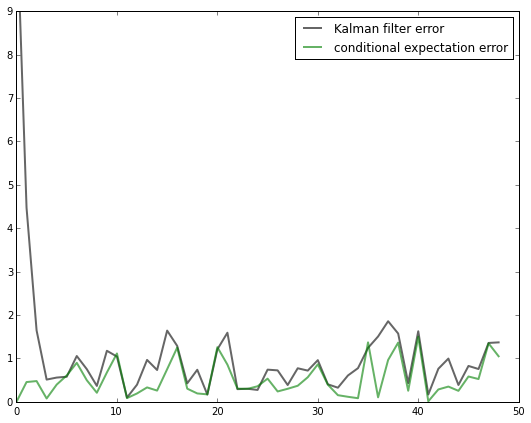

In [151]:
A = np.array([[0.5, 0.4], 
              [0.6, 0.3]])
G = np.eye(2)
Q = 0.3 * np.eye(2)
R = 0.5 * np.eye(2)

init_x_hat = np.array([[8], [8]])
init_Sigma = np.array([[0.9, 0.3],
                       [0.3, 0.9]])

T = 50

'''
Generate the sequence of states X and conditional expectations
'''
X = [] #records the sequence of the state variable
X.append(np.array([[0],[0]]))
AX = [] #records the sequence of conditional expectation of the state variable E[x_{t+1} : x] = Ax
Kalman = [] #records the sequence of Kalman predictions
Conditional_predict_error = []
Kalman_predict_error = []
for i in range(T-1):
    AX.append(dot(A, X[i]))
    Cpredictionerror = np.linalg.norm(AX[i] - X[i])
    Conditional_predict_error.append(Cpredictionerror)
    w = np.random.multivariate_normal(np.array([0, 0]), Q)
    w.shape = (2,1)
    X.append(dot(A, X[i]) + w)

'''
Generate the sequence of Kalman predictions
'''
for i in range(T-1):
    Kalman.append(init_x_hat)
    Kpredictionerror = np.linalg.norm(Kalman[i] - X[i])
    Kalman_predict_error.append(Kpredictionerror)
    v = np.random.multivariate_normal(np.array([0, 0]), R)
    v.shape = (2,1)
    y = X[i] + v
    x_hat_prime, Sigma_prime = Kalman_PredictDist(init_x_hat, y, init_Sigma, A, G, Q, R)
    init_x_hat = x_hat_prime
    init_Sigma = Sigma_prime


fig, ax = plt.subplots(figsize=(9, 7))
ax.set_ylim(0, 9)
ax.set_xlim(0, T)
ax.plot(range(T-1), Kalman_predict_error,'k-', lw=2, alpha=0.6, label='Kalman filter error') 
ax.plot(range(T-1), Conditional_predict_error, 'g-', lw=2, alpha=0.6, label='conditional expectation error')
ax.legend()